In [1]:
import networkx as nx
import pandas as pd
import random
import math
import time
import matplotlib.pyplot as plt
import numpy as np

## Creating the Dataset

In [4]:
# Set a seed for the random number generator
random.seed(0)

# Define the node and edge types
device_types = ['sensor', 'actuator', 'gateway']

sensor_subtypes = ['air_quality_sensor', 'water_level_sensor', 'people_counter', 'water_quality_sensor']
actuator_subtypes = ['smart_streetlights', 'smart_waste_bins']
connection_types = ['short_range', 'local_area', 'wide_area']

num_nodes = 100
num_as = 2  # Number of autonomous systems
nodes_per_as = num_nodes // num_as  # Nodes per autonomous system
num_edges = 100

# Create the graph and add nodes
iot_network = nx.Graph()

for i in range(num_nodes):
    as_id = i // nodes_per_as
    cluster_radius = 5.0
    latitude = random.uniform(as_id * cluster_radius, (as_id + 1) * cluster_radius)
    longitude = random.uniform(as_id * cluster_radius, (as_id + 1) * cluster_radius)
    computing_power = max(1, int(random.normalvariate(50, 15)))
    device_type = random.choice(device_types)
    if device_type == 'sensor':
        device_subtype = random.choice(sensor_subtypes)
    elif device_type == 'actuator':
        device_subtype = random.choice(actuator_subtypes)
    else:
        device_subtype = None

    iot_network.add_node(i, as_id=as_id, latitude=latitude, longitude=longitude,
                         computing_power=computing_power, device_type=device_type,
                         device_subtype=device_subtype)

# Add edges
for _ in range(num_edges):
    node1, node2 = random.sample(range(num_nodes), 2)
    lat1, lon1 = iot_network.nodes[node1]['latitude'], iot_network.nodes[node1]['longitude']
    lat2, lon2 = iot_network.nodes[node2]['latitude'], iot_network.nodes[node2]['longitude']
    distance = math.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2)
    link_capacity = max(1, int(100 / distance) * iot_network.nodes[node1]['computing_power'])
    connection_type = random.choice(connection_types)
    traffic_volume = 10 if iot_network.nodes[node1]['device_type'] == 'sensor' else 0

    link_quality = random.uniform(0.5, 1.0)  # Random link quality between 0.5 and 1
    traffic_load = random.uniform(0.1, 1.0)  # Random traffic load between 0.1 and 1

    iot_network.add_edge(node1, node2, capacity=link_capacity, connection_type=connection_type,
                         traffic_volume=traffic_volume, link_quality=link_quality, traffic_load=traffic_load)

# Convert to DataFrames
node_df = pd.DataFrame.from_dict(dict(iot_network.nodes(data=True)), orient='index')
node_df.index.name = 'Node_ID'
node_df.reset_index(inplace=True)

edge_list = [(node1, node2, attrs['capacity'], attrs['connection_type'], attrs['traffic_volume'])
             for node1, node2, attrs in iot_network.edges(data=True)]
edge_df = pd.DataFrame(edge_list, columns=['Node1', 'Node2', 'Capacity', 'Connection_Type', 'Traffic_Volume'])
node_df[:5]

,Node_ID,as_id,latitude,longitude,computing_power,device_type,device_subtype
0,0,0,4.222109,3.789772,47,gateway,None
1,1,0,2.429638,4.591172,16,sensor,water_level_sensor
2,2,0,1.409189,3.779021,54,gateway,None
3,3,0,4.913927,4.051086,65,gateway,None
4,4,0,0.368712,4.252369,40,actuator,smart_waste_bins


In [5]:
edge_df[:5]

,Node1,Node2,Capacity,Connection_Type,Traffic_Volume
0,0,79,779,local_area,0
1,0,44,900,local_area,0
2,1,67,400,short_range,10
3,1,70,192,wide_area,10
4,1,39,1888,wide_area,10


## Visualization

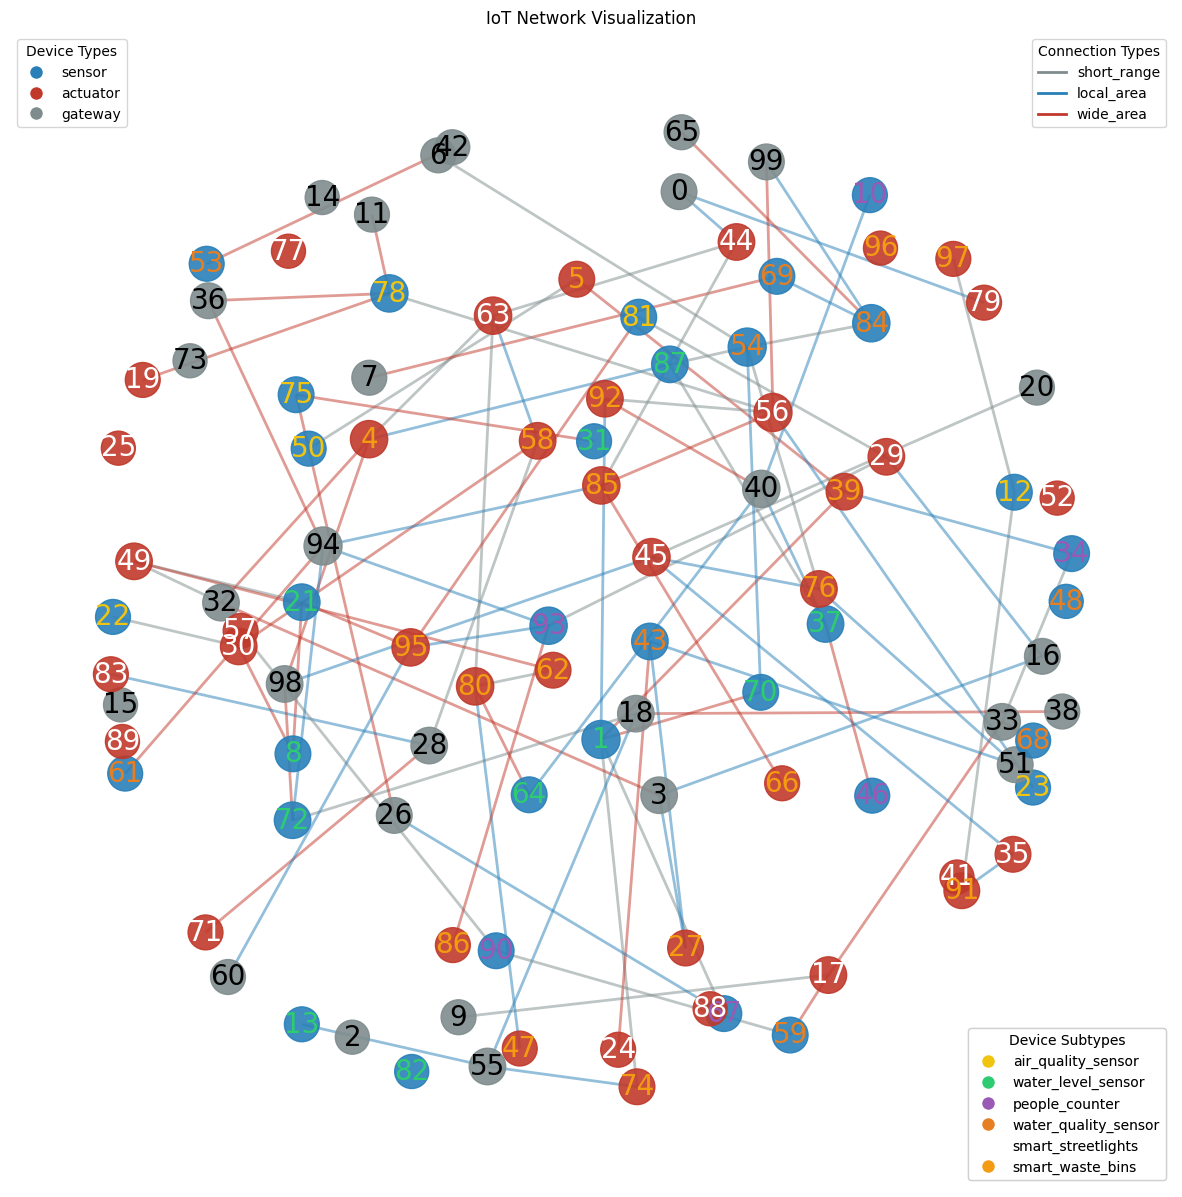

In [8]:
plt.figure(figsize=(15, 15))

device_colors = {
    "sensor": "#2980B9", 
    "actuator": "#C0392B",  
    "gateway": "#7F8C8D"  
}

device_subtype_colors = {
    "air_quality_sensor": "#F1C40F",  
    "water_level_sensor": "#2ECC71",  
    "people_counter": "#9B59B6",  
    "water_quality_sensor": "#E67E22", 
    "smart_streetlights": "#FFFFFF",  
    "smart_waste_bins": "#F39C12"  
}

connection_colors = {
    "short_range": "#7F8C8D",  
    "local_area": "#2980B9",  
    "wide_area": "#C0392B"  
}

default_label_color = "black"

label_colors = [device_subtype_colors.get(node[1].get('device_subtype', default_label_color), default_label_color) for node in iot_network.nodes(data=True)]
node_colors = [device_colors[node[1]['device_type']] for node in iot_network.nodes(data=True)]
edge_colors = [connection_colors[edge[2]['connection_type']] for edge in iot_network.edges(data=True)]

pos = nx.spring_layout(iot_network, seed=1, k=0.7)

node_sizes = [600 + 30 * len(list(iot_network.neighbors(n))) for n in iot_network.nodes()]

edge_widths = [2 for edge in iot_network.edges(data=True)] 

nx.draw_networkx_nodes(iot_network, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(iot_network, pos, width=edge_widths, edge_color=edge_colors, alpha=0.5)
for idx, (node, data) in enumerate(iot_network.nodes(data=True)):
    plt.text(pos[node][0], pos[node][1], node, color=label_colors[idx], fontsize=20, ha='center', va='center')

device_legend = plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=device, markersize=10, markerfacecolor=color) 
                            for device, color in device_colors.items()], loc="upper left", title="Device Types")
plt.gca().add_artist(device_legend)

connection_legend = plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=connection) 
                                  for connection, color in connection_colors.items()], loc="upper right", title="Connection Types")
plt.gca().add_artist(connection_legend)

device_subtype_legend = plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=subtype, markersize=10, markerfacecolor=color) 
                                     for subtype, color in device_subtype_colors.items()], loc="lower right", title="Device Subtypes")
plt.gca().add_artist(device_subtype_legend)

plt.title("IoT Network Visualization")
plt.axis('off')
plt.show()

## Visualization with Weights

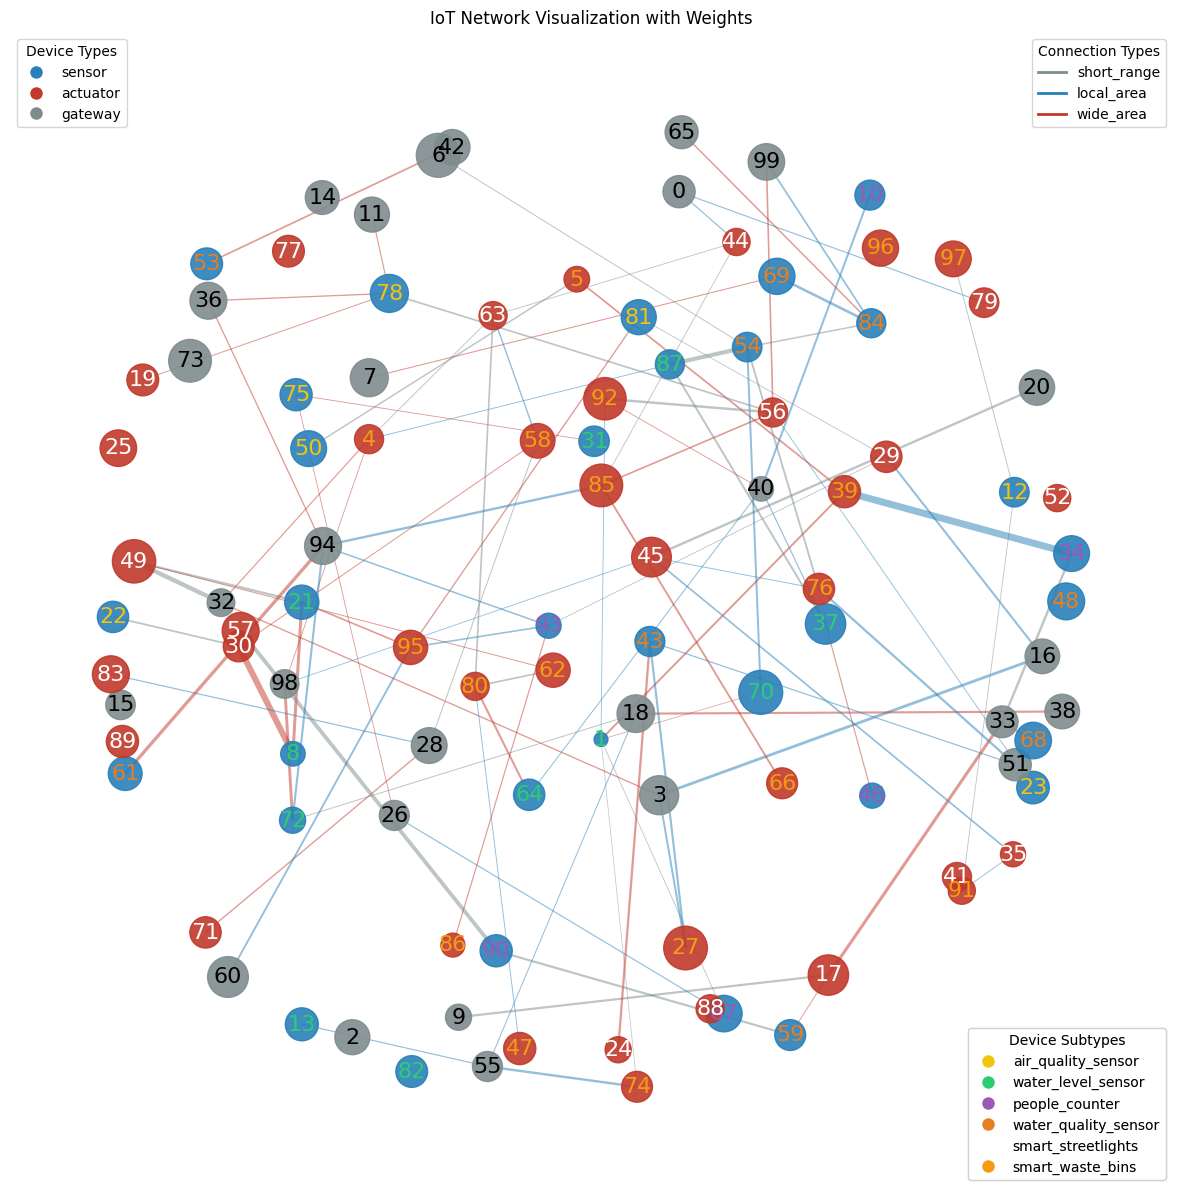

In [9]:
plt.figure(figsize=(15, 15))

device_colors = {
    "sensor": "#2980B9", 
    "actuator": "#C0392B",  
    "gateway": "#7F8C8D"  
}

device_subtype_colors = {
    "air_quality_sensor": "#F1C40F",  
    "water_level_sensor": "#2ECC71",  
    "people_counter": "#9B59B6",  
    "water_quality_sensor": "#E67E22", 
    "smart_streetlights": "#FFFFFF",  
    "smart_waste_bins": "#F39C12"  
}

connection_colors = {
    "short_range": "#7F8C8D",  
    "local_area": "#2980B9",  
    "wide_area": "#C0392B"  
}

default_label_color = "black"

label_colors = [device_subtype_colors.get(node[1].get('device_subtype', default_label_color), default_label_color) for node in iot_network.nodes(data=True)]
node_colors = [device_colors[node[1]['device_type']] for node in iot_network.nodes(data=True)]
edge_colors = [connection_colors[edge[2]['connection_type']] for edge in iot_network.edges(data=True)]

pos = nx.spring_layout(iot_network, seed=1, k=0.7)

min_node_size = 100
max_node_size = 1000
min_computing_power = min([data['computing_power'] for _, data in iot_network.nodes(data=True)])
max_computing_power = max([data['computing_power'] for _, data in iot_network.nodes(data=True)])

node_sizes = [min_node_size + (data['computing_power'] - min_computing_power) * (max_node_size - min_node_size) / (max_computing_power - min_computing_power)
             for _, data in iot_network.nodes(data=True)]

min_edge_width = 0.5
max_edge_width = 5
min_capacity = min([data['capacity'] for _, _, data in iot_network.edges(data=True)])
max_capacity = max([data['capacity'] for _, _, data in iot_network.edges(data=True)])

edge_widths = [min_edge_width + (data['capacity'] - min_capacity) * (max_edge_width - min_edge_width) / (max_capacity - min_capacity)
              for _, _, data in iot_network.edges(data=True)]

nx.draw_networkx_nodes(iot_network, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(iot_network, pos, width=edge_widths, edge_color=edge_colors, alpha=0.5)
for idx, (node, data) in enumerate(iot_network.nodes(data=True)):
    plt.text(pos[node][0], pos[node][1], node, color=label_colors[idx], fontsize=16, ha='center', va='center')
    
device_legend = plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=device, markersize=10, markerfacecolor=color) 
                            for device, color in device_colors.items()], loc="upper left", title="Device Types")
plt.gca().add_artist(device_legend)

connection_legend = plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=connection) 
                                  for connection, color in connection_colors.items()], loc="upper right", title="Connection Types")
plt.gca().add_artist(connection_legend)

device_subtype_legend = plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=subtype, markersize=10, markerfacecolor=color) 
                                     for subtype, color in device_subtype_colors.items()], loc="lower right", title="Device Subtypes")
plt.gca().add_artist(device_subtype_legend)

plt.title("IoT Network Visualization with Weights")
plt.axis('off')
plt.show()

## Network Structure Properties

In [10]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(iot_network)
betweenness_centrality = nx.betweenness_centrality(iot_network)
closeness_centrality = nx.closeness_centrality(iot_network)
eigenvector_centrality = nx.eigenvector_centrality(iot_network)

# Create a DataFrame to view the data
df_centrality = pd.DataFrame({
    'Node': iot_network.nodes(),
    'Degree Centrality': [degree_centrality[node] for node in iot_network.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in iot_network.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in iot_network.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in iot_network.nodes()],
})

# Display top 5 nodes for each centrality measure
top_degree_nodes = df_centrality.sort_values(by='Degree Centrality', ascending=False).head(5)
top_betweenness_nodes = df_centrality.sort_values(by='Betweenness Centrality', ascending=False).head(5)
top_closeness_nodes = df_centrality.sort_values(by='Closeness Centrality', ascending=False).head(5)
top_eigenvector_nodes = df_centrality.sort_values(by='Eigenvector Centrality', ascending=False).head(5)
top_degree_nodes

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
1,1,0.050505,0.249759,0.192110,0.176659
94,94,0.050505,0.127685,0.189555,0.287852
54,54,0.050505,0.162286,0.197431,0.208364
56,56,0.050505,0.151154,0.197431,0.290987
84,84,0.040404,0.065244,0.176418,0.146929


In [11]:
top_betweenness_nodes

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
1,1,0.050505,0.249759,0.192110,0.176659
54,54,0.050505,0.162286,0.197431,0.208364
39,39,0.030303,0.155844,0.164223,0.075675
56,56,0.050505,0.151154,0.197431,0.290987
92,92,0.030303,0.147186,0.194734,0.200688


In [12]:
top_closeness_nodes

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
4,4,0.040404,0.142922,0.201335,0.217918
85,85,0.040404,0.130262,0.197980,0.274303
56,56,0.050505,0.151154,0.197431,0.290987
54,54,0.050505,0.162286,0.197431,0.208364
87,87,0.030303,0.088796,0.195268,0.177229


In [13]:
top_eigenvector_nodes

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
56,56,0.050505,0.151154,0.197431,0.290987
94,94,0.050505,0.127685,0.189555,0.287852
85,85,0.040404,0.130262,0.197980,0.274303
4,4,0.040404,0.142922,0.201335,0.217918
54,54,0.050505,0.162286,0.197431,0.208364


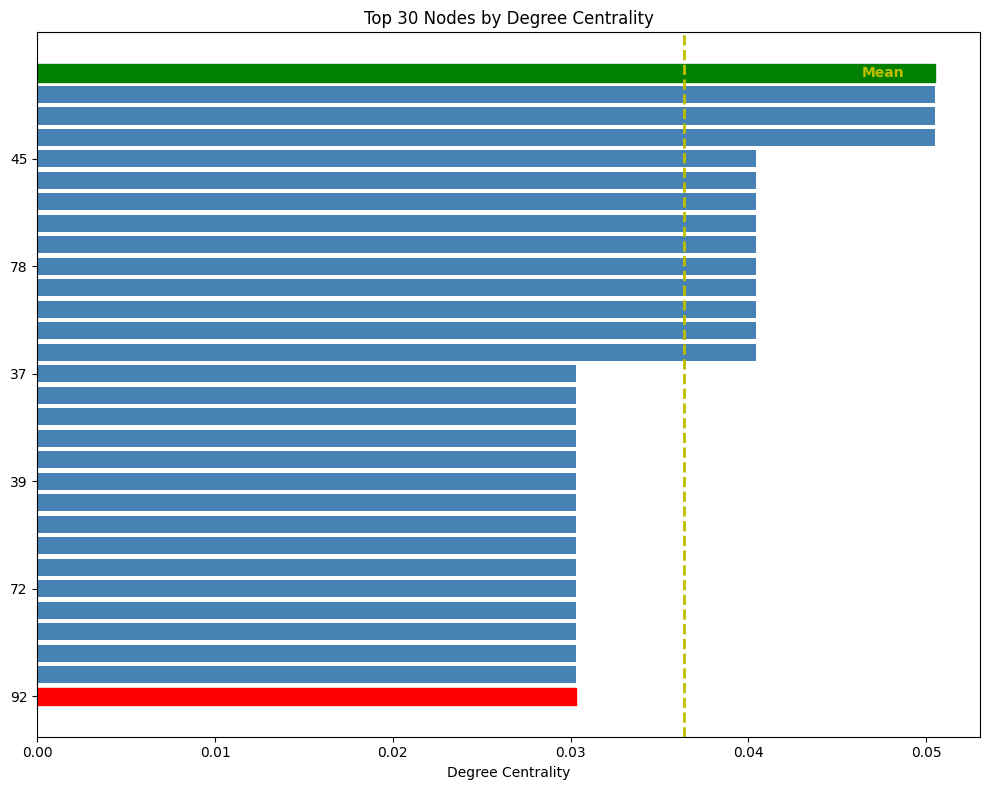

In [15]:
def plot_centrality_with_stats(df, centrality_col, title, top_n=30, nth_label=5):
    # Sort the dataframe and take the top N nodes
    sorted_df = df.sort_values(by=centrality_col, ascending=True).tail(top_n)
    
    # Calculate min, max, and mean
    min_val = sorted_df[centrality_col].min()
    max_val = sorted_df[centrality_col].max()
    mean_val = sorted_df[centrality_col].mean()
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(sorted_df['Node'].astype(str), sorted_df[centrality_col], color='steelblue')
    
    # Highlight the bars representing min and max values
    bars[0].set_color('r')  # Min in the top N nodes
    bars[-1].set_color('g')  # Max in the top N nodes
    
    # Plot mean line
    plt.axvline(mean_val, color='y', linestyle='dashed', linewidth=2)
    
    # Set text annotations
    plt.text(mean_val+0.01, top_n-1, 'Mean', color='y', fontweight='bold', va='center')
    
    # Reduce the number of y-ticks by showing every nth label
    y_ticks = plt.yticks()[0]
    n = len(y_ticks)
    plt.yticks(y_ticks[::nth_label], sorted_df['Node'].astype(str).tolist()[::nth_label])
    
    plt.xlabel(centrality_col)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot using the modified function
plot_centrality_with_stats(df_centrality, 'Degree Centrality', 'Top 30 Nodes by Degree Centrality')


Sensor minimum degree centrality:  0.0
Sensor maximum degree centrality:  0.05050505050505051
Sensor average degree centrality:  0.021120293847566578
-----
Actuator minimum degree centrality:  0.0
Actuator maximum degree centrality:  0.05050505050505051
Actuator average degree centrality:  0.0202020202020202


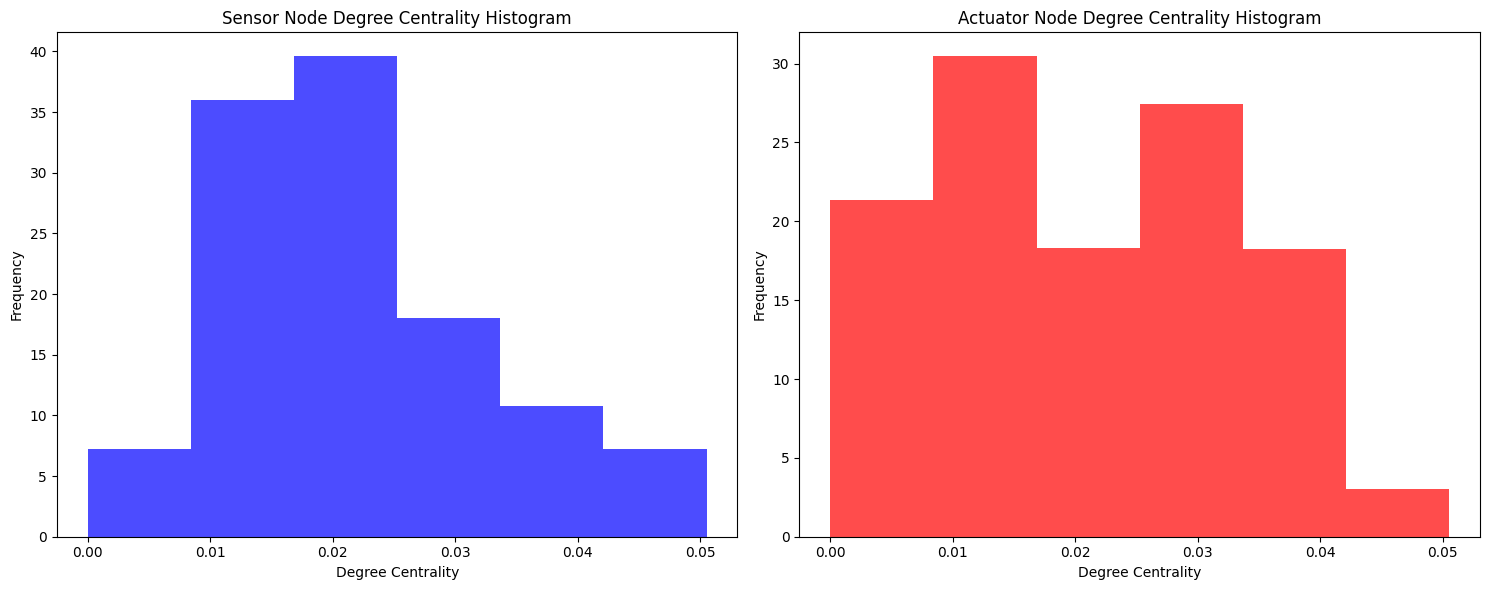

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Filter rows for sensors and actuators
sensor_df = df_centrality[df_centrality['Node'].isin(node_df[node_df['device_type'] == 'sensor']['Node_ID'])]
actuator_df = df_centrality[df_centrality['Node'].isin(node_df[node_df['device_type'] == 'actuator']['Node_ID'])]

# Extract degree centrality values
sensor_degrees = sensor_df['Degree Centrality'].values
actuator_degrees = actuator_df['Degree Centrality'].values

# Compute min, max, avg for sensors
sensor_min_degree = np.min(sensor_degrees)
sensor_max_degree = np.max(sensor_degrees)
sensor_avg_degree = np.mean(sensor_degrees)

print("Sensor minimum degree centrality: ", sensor_min_degree)
print("Sensor maximum degree centrality: ", sensor_max_degree)
print("Sensor average degree centrality: ", sensor_avg_degree)

print('-----')

# Compute min, max, avg for actuators
actuator_min_degree = np.min(actuator_degrees)
actuator_max_degree = np.max(actuator_degrees)
actuator_avg_degree = np.mean(actuator_degrees)

print("Actuator minimum degree centrality: ", actuator_min_degree)
print("Actuator maximum degree centrality: ", actuator_max_degree)
print("Actuator average degree centrality: ", actuator_avg_degree)

# Create two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for sensor degrees using matplotlib
ax[0].hist(sensor_degrees, color='blue', bins=6, density=True, alpha=0.7, label="Frequency")
ax[0].set_title('Sensor Node Degree Centrality Histogram')
ax[0].set_xlabel('Degree Centrality')
ax[0].set_ylabel('Frequency')

# Plot histogram for actuator degrees using matplotlib
ax[1].hist(actuator_degrees, color='red', bins=6, density=True, alpha=0.7, label="Frequency")
ax[1].set_title('Actuator Node Degree Centrality Histogram')
ax[1].set_xlabel('Degree Centrality')
ax[1].set_ylabel('Frequency')

# Adjust space between plots
plt.tight_layout()

# Show the plot
plt.show()


In [31]:
# List the edges sorted by their traffic load
high_traffic_edges = sorted(iot_network.edges(data=True), key=lambda x: x[2]['traffic_load'], reverse=True)

# Top 5 edges with highest traffic
for edge in high_traffic_edges[:5]:
    print(f"Edge between {edge[0]} and {edge[1]} has a traffic load of {edge[2]['traffic_load']}")


Edge between 32 and 49 has a traffic load of 0.9835516772903383
Edge between 33 and 68 has a traffic load of 0.9825649218110886
Edge between 22 and 30 has a traffic load of 0.9609079891876896
Edge between 1 and 74 has a traffic load of 0.9570760414758552
Edge between 43 and 51 has a traffic load of 0.9499786954621517


In [32]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(iot_network)

# Extract computing power for each node
computing_powers = nx.get_node_attributes(iot_network, 'computing_power')

# Create lists of nodes, their degree centrality, and their computing power
nodes = list(iot_network.nodes())
degrees = [degree_centrality[node] for node in nodes]
computing_power_list = [computing_powers[node] for node in nodes]

# Use a statistical measure like Pearson's correlation to check the relationship
from scipy.stats import pearsonr

correlation_coefficient, p_value = pearsonr(degrees, computing_power_list)
print(f"Pearson correlation coefficient between degree centrality and computing power: {correlation_coefficient}")


Pearson correlation coefficient between degree centrality and computing power: -0.08828201742619309


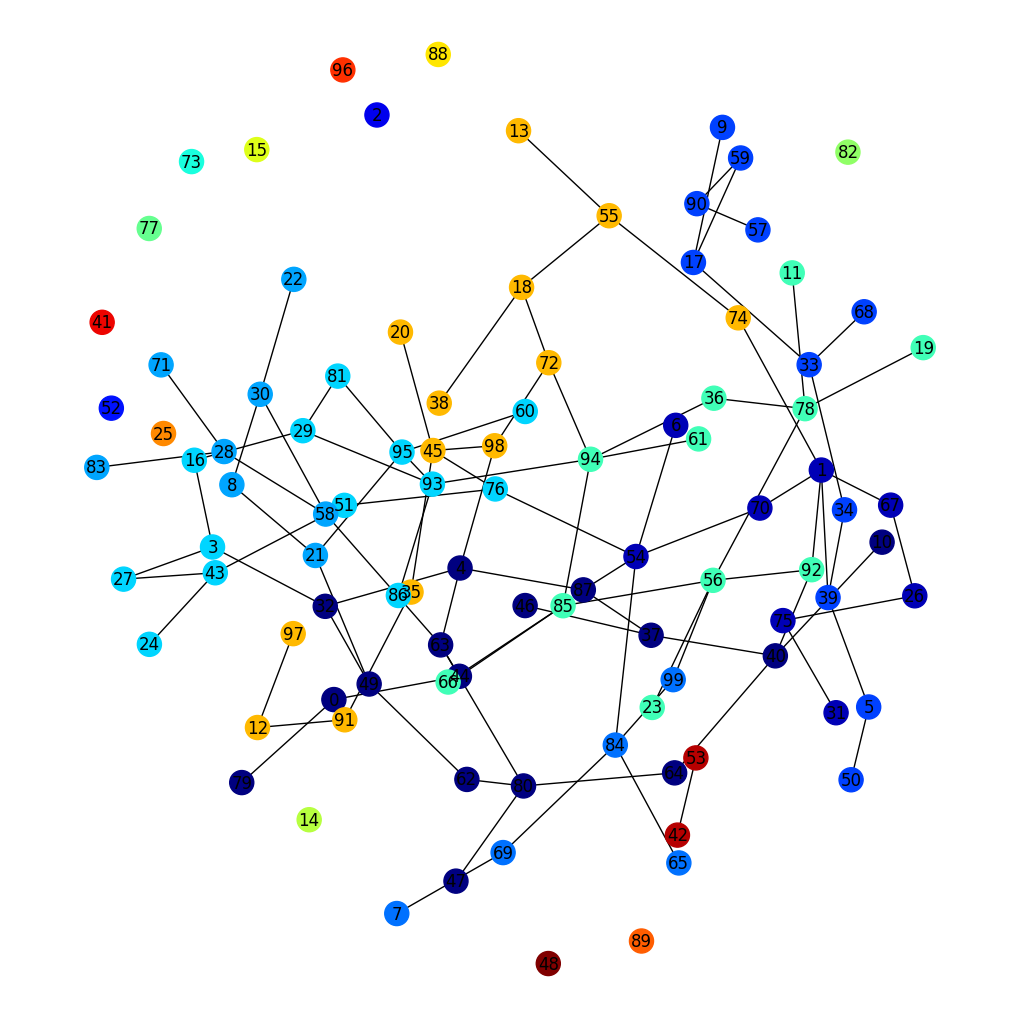

Identified 22 communities.


In [33]:
import community as community_louvain
import matplotlib.pyplot as plt

partition = community_louvain.best_partition(iot_network)

# Visualize the communities
pos = nx.spring_layout(iot_network, seed=0, k=0.3)
cmap = plt.cm.jet
plt.figure(figsize=(10, 10))
nx.draw(iot_network, pos, node_color=[partition[node] for node in iot_network.nodes()], cmap=cmap, with_labels=True)
plt.show()

print(f"Identified {len(set(partition.values()))} communities.")


C:\Users\Francis\AppData\Local\Temp\ipykernel_10244\685578275.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', num_communities)
C:\Users\Francis\AppData\Local\Temp\ipykernel_10244\685578275.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), orientation='horizontal', pad=0.03, ticks=[])


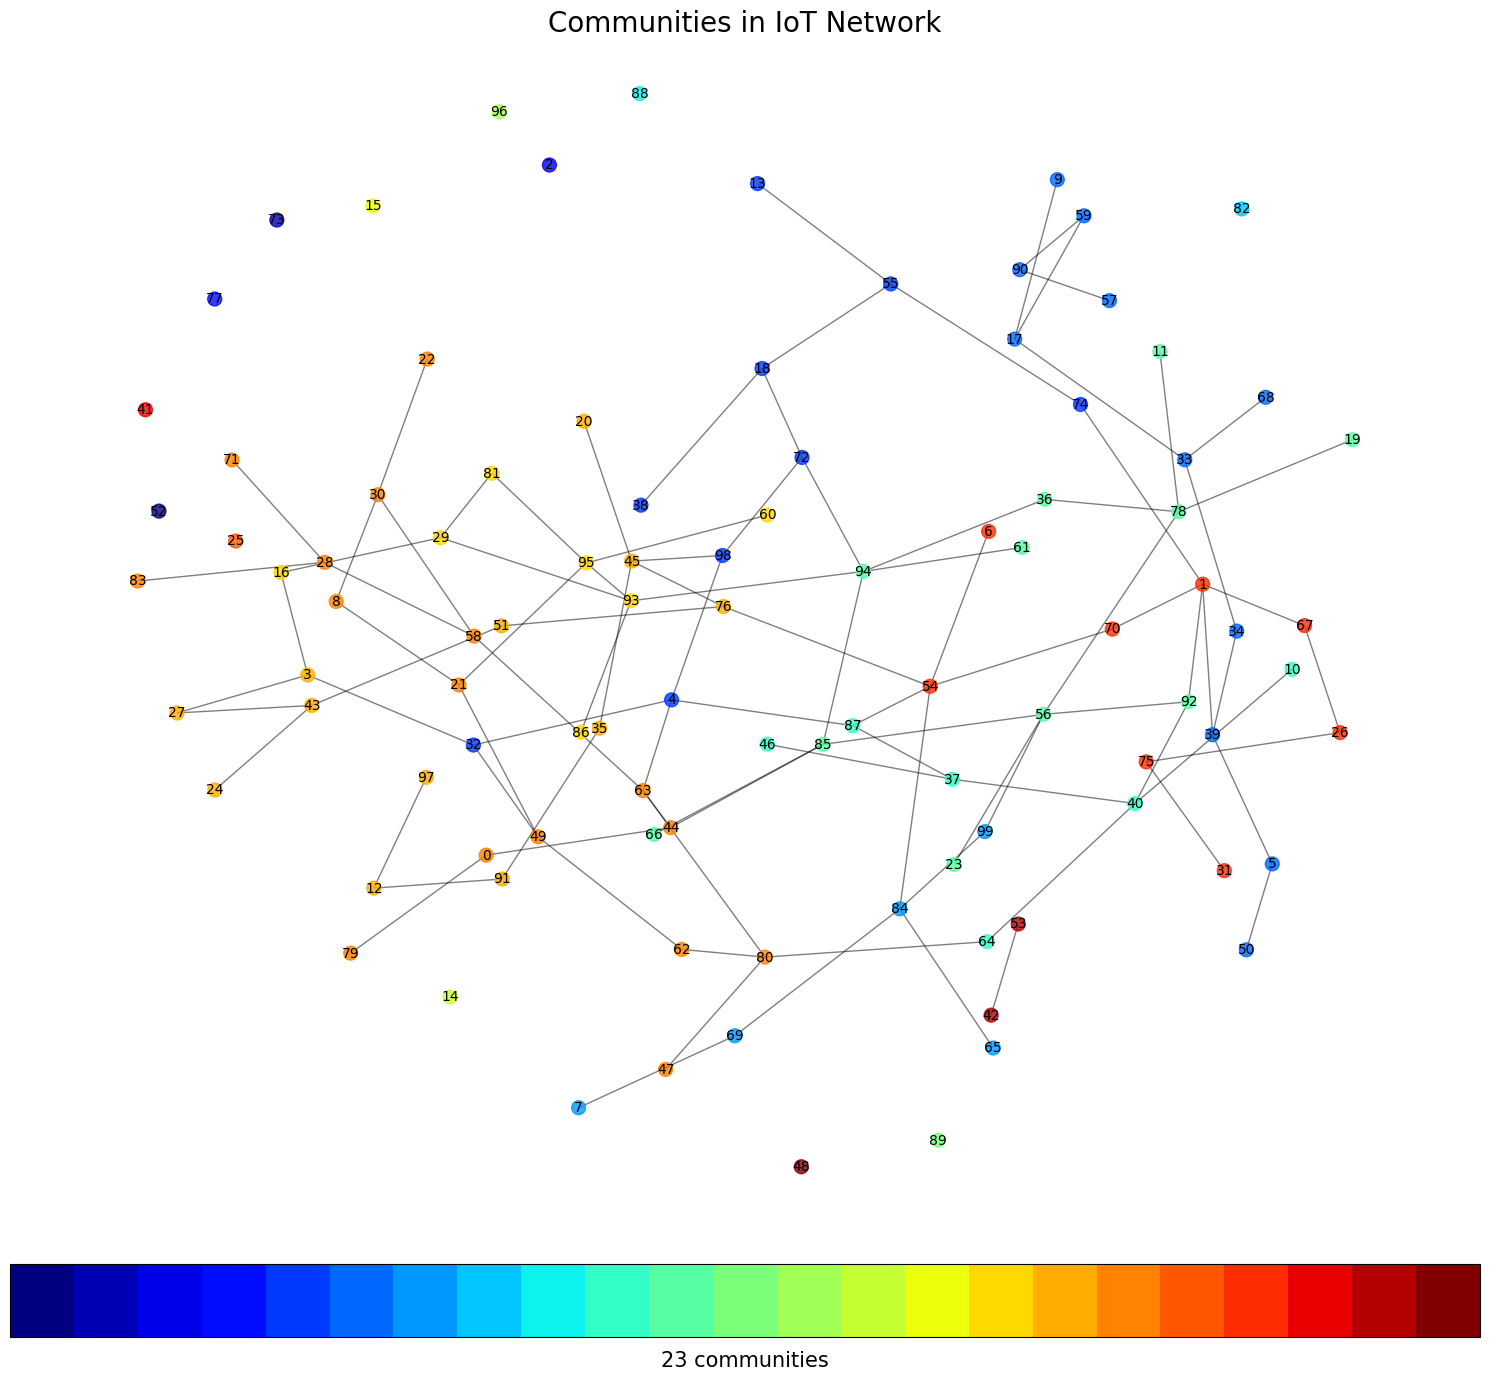

In [34]:
import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx

# Compute the best partition
partition = community_louvain.best_partition(iot_network)

# Compute the layout
pos = nx.spring_layout(iot_network, seed=0, k=0.3)

# Set up a color map (one color for each community)
num_communities = len(set(partition.values()))
cmap = plt.cm.get_cmap('jet', num_communities)

# Draw the graph
plt.figure(figsize=(15, 15))

# Draw nodes
nx.draw_networkx_nodes(iot_network, pos, node_color=[partition[node] for node in iot_network.nodes()], 
                       cmap=cmap, node_size=100, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(iot_network, pos, alpha=0.5, width=1)

# Draw node labels
nx.draw_networkx_labels(iot_network, pos, font_size=10)

# Add a title and a legend
plt.title("Communities in IoT Network", fontsize=20)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), orientation='horizontal', pad=0.03, ticks=[])
cbar.set_label(f"{num_communities} communities", labelpad=10, fontsize=15)

plt.axis("off")
plt.tight_layout()
plt.show()


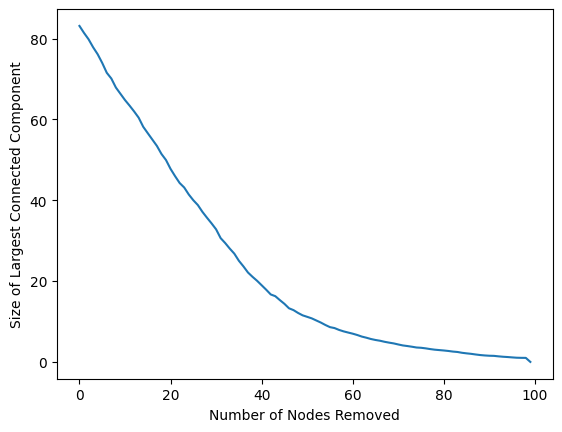

In [35]:
import numpy as np

def robustness_analysis(G, iterations=100):
    nodes = list(G.nodes())
    sizes = []

    for i in range(iterations):
        G_temp = G.copy()
        random_nodes = list(G.nodes())
        np.random.shuffle(random_nodes)

        size = []
        for node in random_nodes:
            G_temp.remove_node(node)
            if len(G_temp) == 0:  # Check if the graph is empty
                size.append(0)
            else:
                largest_cc = len(max(nx.connected_components(G_temp), key=len))
                size.append(largest_cc)
        sizes.append(size)

    average_size = np.mean(sizes, axis=0)

    return average_size

size_after_removals = robustness_analysis(iot_network)
plt.plot(size_after_removals)
plt.xlabel("Number of Nodes Removed")
plt.ylabel("Size of Largest Connected Component")
plt.show()


In [36]:
size_after_removals

array([83.16, 81.43, 79.86, 77.88, 76.15, 74.  , 71.56, 70.14, 67.91,
       66.36, 64.81, 63.44, 62.  , 60.45, 58.2 , 56.61, 55.04, 53.47,
       51.48, 49.97, 47.78, 45.97, 44.28, 43.17, 41.44, 40.02, 38.82,
       37.14, 35.69, 34.3 , 32.82, 30.64, 29.42, 28.05, 26.8 , 25.04,
       23.65, 22.13, 21.06, 20.08, 18.98, 17.87, 16.7 , 16.27, 15.3 ,
       14.38, 13.28, 12.82, 12.12, 11.53, 11.16, 10.78, 10.26,  9.74,
        9.14,  8.61,  8.38,  7.92,  7.56,  7.27,  6.99,  6.66,  6.27,
        5.99,  5.67,  5.43,  5.24,  4.98,  4.77,  4.58,  4.32,  4.08,
        3.93,  3.76,  3.57,  3.5 ,  3.36,  3.18,  3.03,  2.93,  2.83,
        2.71,  2.56,  2.46,  2.26,  2.12,  2.  ,  1.84,  1.7 ,  1.6 ,
        1.53,  1.5 ,  1.38,  1.28,  1.21,  1.12,  1.04,  1.01,  1.  ,
        0.  ])

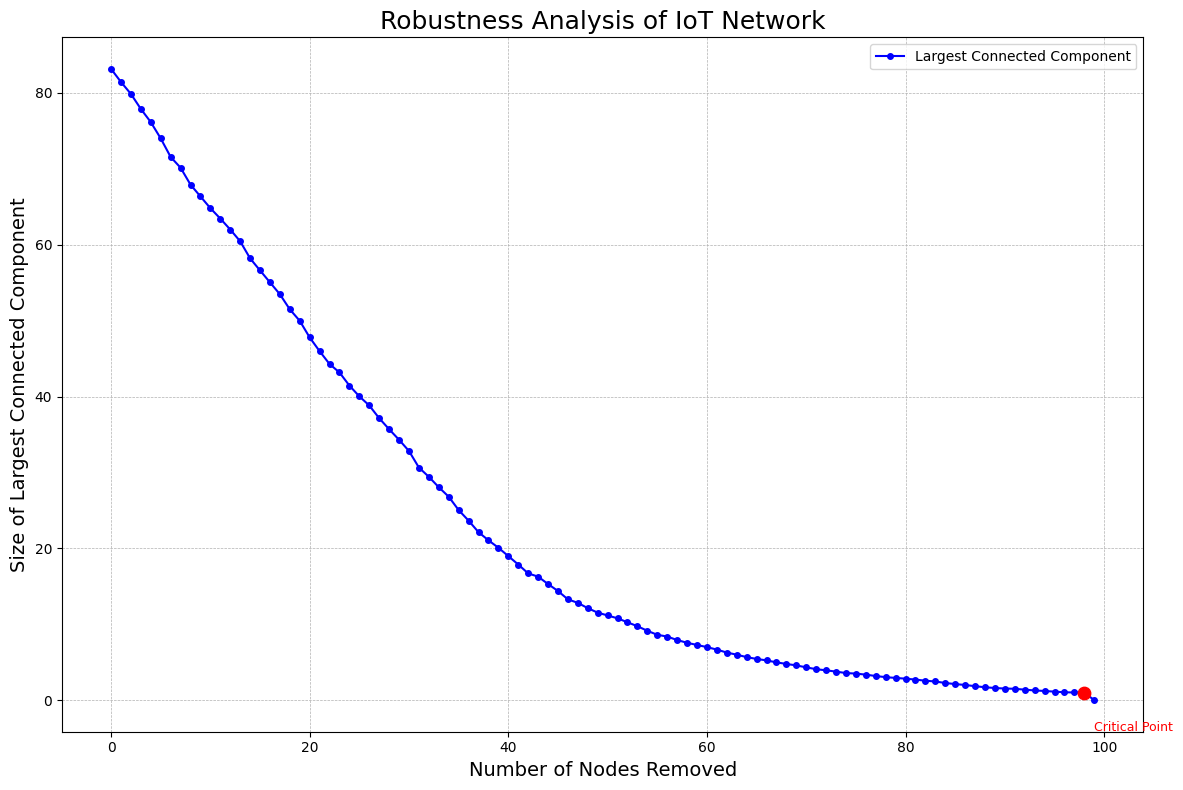

In [37]:
import matplotlib.pyplot as plt

# Improved visualization
plt.figure(figsize=(12, 8))

# Plot the data
plt.plot(size_after_removals, '-o', markersize=4, lw=1.5, color='b', label="Largest Connected Component")

# Highlight the point where the size becomes 1, which indicates complete disconnection
critical_point = np.where(size_after_removals == 1)[0][0]
plt.scatter(critical_point, size_after_removals[critical_point], color='r', s=80, zorder=5)
plt.text(critical_point+1, size_after_removals[critical_point]-5, 'Critical Point', fontsize=9, color='red')

# Titles and labels
plt.title("Robustness Analysis of IoT Network", fontsize=18)
plt.xlabel("Number of Nodes Removed", fontsize=14)
plt.ylabel("Size of Largest Connected Component", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
# Find the largest connected component
largest_cc = max(nx.connected_components(iot_network), key=len)

# Create a subgraph from the largest connected component
lcc_subgraph = iot_network.subgraph(largest_cc)

# Compute the diameter of the subgraph
diameter = nx.diameter(lcc_subgraph)
print(f"The diameter of the largest connected component is: {diameter}")


The diameter of the largest connected component is: 15


In [41]:
# Find the largest connected component
largest_cc = max(nx.connected_components(iot_network), key=len)

# Create a subgraph from the largest connected component
lcc_subgraph = iot_network.subgraph(largest_cc)

# Compute the average shortest path length for the subgraph
average_shortest_path_length = nx.average_shortest_path_length(lcc_subgraph)
print(f"The average shortest path length for the largest connected component is: {average_shortest_path_length}")


The average shortest path length for the largest connected component is: 5.873949579831932
